In [12]:
%pylab inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


C:\Users\46145\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
train = MNIST('./data', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

test = MNIST('./data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

# Create DataLoader
dataloader_args = dict(shuffle=True, batch_size=64,num_workers=1, pin_memory=True)
train_loader = dataloader.DataLoader(train, **dataloader_args)
test_loader = dataloader.DataLoader(test, **dataloader_args)

In [3]:
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - Transformed Shape:', train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

C:\Users\46145\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - Transformed Shape: torch.Size([28, 60000, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


In [7]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.fc1 = nn.Linear(784, 300)
        #self.bc1 = nn.BatchNorm1d(548)
        
        self.fc2 = nn.Linear(300, 10)
        #self.bc2 = nn.BatchNorm1d(252)
        
        #self.fc3 = nn.Linear(252, 10)
        
        
    def forward(self, x):
        x = x.view((-1, 784))
        h = self.fc1(x)
        #h = self.bc1(h)
        sh = F.sigmoid(h)
        #h = F.dropout(h, p=0.5, training=self.training)
        
        z = self.fc2(sh)
        #h = self.bc2(h)
        #h = F.relu(h)
        #h = F.dropout(h, p=0.2, training=self.training)
        
        #h = self.fc3(h)
        out = F.softmax(h)
        return out

model = Model()
model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Train

In [8]:
model.train()

losses = []
for epoch in range(15):
    for batch_idx, (data, target) in enumerate(train_loader):
        # Get Samples
        data, target = Variable(data.cuda()), Variable(target.cuda())
        
        # Init
        optimizer.zero_grad()

        # Predict
        y_pred = model(data) 

        # Calculate loss
        loss = F.cross_entropy(y_pred, target)
        
        #print(loss)
        tmp = loss.item()
        losses.append(tmp)
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        
        # Display
        if batch_idx % 100 == 1:
            print('\r Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, 
                batch_idx * len(data), 
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader), 
                loss.item()), 
                end='')
            
    print()

C:\Users\46145\anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
<ipython-input-7-6a6224c04aaa>:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(h)


 Train Epoch: 0 [57664/60000 (96%)]	Loss: 4.819601
 Train Epoch: 1 [57664/60000 (96%)]	Loss: 4.849546
 Train Epoch: 2 [57664/60000 (96%)]	Loss: 4.851287
 Train Epoch: 3 [57664/60000 (96%)]	Loss: 4.781395
 Train Epoch: 4 [57664/60000 (96%)]	Loss: 4.789785
 Train Epoch: 5 [57664/60000 (96%)]	Loss: 4.780805
 Train Epoch: 6 [57664/60000 (96%)]	Loss: 4.767251
 Train Epoch: 7 [57664/60000 (96%)]	Loss: 4.780898
 Train Epoch: 8 [57664/60000 (96%)]	Loss: 4.813853
 Train Epoch: 9 [57664/60000 (96%)]	Loss: 4.749021
 Train Epoch: 10 [57664/60000 (96%)]	Loss: 4.798348
 Train Epoch: 11 [57664/60000 (96%)]	Loss: 4.788637
 Train Epoch: 12 [57664/60000 (96%)]	Loss: 4.778802
 Train Epoch: 13 [57664/60000 (96%)]	Loss: 4.758847
 Train Epoch: 14 [57664/60000 (96%)]	Loss: 4.768726


Text(0, 0.5, 'cross entropy loss')

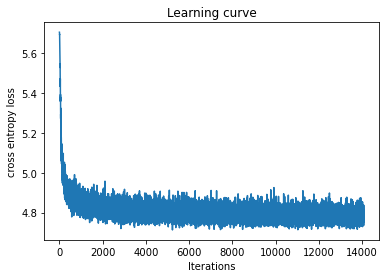

In [13]:
plt.plot(losses)

plt.title("Learning curve")
plt.xlabel("Iterations")
plt.ylabel("cross entropy loss")


In [10]:
evaluate_x = Variable(test_loader.dataset.test_data.type_as(torch.FloatTensor())).cuda()
evaluate_y = Variable(test_loader.dataset.test_labels).cuda()


output = model(evaluate_x)
pred = output.data.max(1)[1]
d = pred.eq(evaluate_y.data).cpu()
accuracy = d.sum()/d.size()[0]

print('Accuracy:', accuracy)

Accuracy: tensor(0.9265)


C:\Users\46145\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
C:\Users\46145\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
<ipython-input-7-6a6224c04aaa>:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(h)


In [20]:
model0 = Model()
nn.init.constant_(model0.fc1.weight, 0)
nn.init.constant_(model0.fc1.bias, 0)
nn.init.constant_(model0.fc2.weight, 0)
nn.init.constant_(model0.fc2.bias, 0)
model0.cuda()
optimizer = optim.Adam(model0.parameters(), lr=0.001)

In [26]:
model0.train()

losses = []
for epoch in range(15):
    for batch_idx, (data, target) in enumerate(train_loader):
        # Get Samples
        data, target = Variable(data.cuda()), Variable(target.cuda())
        
        # Init
        optimizer.zero_grad()

        # Predict
        y_pred = model0(data) 

        # Calculate loss
        loss = F.cross_entropy(y_pred, target)
        
        #print(loss)
        tmp = loss.item()
        losses.append(tmp)
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        
        # Display
        if batch_idx % 100 == 1:
            print('\r Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, 
                batch_idx * len(data), 
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader), 
                loss.item()), 
                end='')
            
    print()

C:\Users\46145\anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
<ipython-input-7-6a6224c04aaa>:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(h)


 Train Epoch: 0 [57664/60000 (96%)]	Loss: 4.856697
 Train Epoch: 1 [57664/60000 (96%)]	Loss: 4.841415
 Train Epoch: 2 [57664/60000 (96%)]	Loss: 4.778615
 Train Epoch: 3 [57664/60000 (96%)]	Loss: 4.761837
 Train Epoch: 4 [57664/60000 (96%)]	Loss: 4.757173
 Train Epoch: 5 [57664/60000 (96%)]	Loss: 4.790073
 Train Epoch: 6 [57664/60000 (96%)]	Loss: 4.814324
 Train Epoch: 7 [57664/60000 (96%)]	Loss: 4.788912
 Train Epoch: 8 [57664/60000 (96%)]	Loss: 4.818263
 Train Epoch: 9 [57664/60000 (96%)]	Loss: 4.804187
 Train Epoch: 10 [57664/60000 (96%)]	Loss: 4.747469
 Train Epoch: 11 [57664/60000 (96%)]	Loss: 4.837744
 Train Epoch: 12 [57664/60000 (96%)]	Loss: 4.821943
 Train Epoch: 13 [57664/60000 (96%)]	Loss: 4.808532
 Train Epoch: 14 [57664/60000 (96%)]	Loss: 4.790094


Text(0, 0.5, 'cross entropy loss')

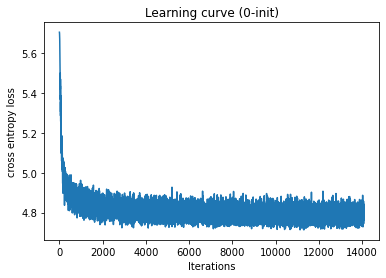

In [29]:
plt.plot(losses)

plt.title("Learning curve (0-init)")
plt.xlabel("Iterations")
plt.ylabel("cross entropy loss")

In [28]:
evaluate_x = Variable(test_loader.dataset.test_data.type_as(torch.FloatTensor())).cuda()
evaluate_y = Variable(test_loader.dataset.test_labels).cuda()


output = model0(evaluate_x)
pred = output.data.max(1)[1]
d = pred.eq(evaluate_y.data).cpu()
accuracy = d.sum()/d.size()[0]
#print(d)
print('Accuracy:', accuracy)

C:\Users\46145\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
C:\Users\46145\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
C:\Users\46145\anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
<ipython-input-7-6a6224c04aaa>:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(h)


Accuracy: tensor(0.9245)


In [34]:
model1 = Model()
nn.init.uniform_(model1.fc1.weight, -1,1)
nn.init.uniform_(model1.fc1.bias, -1,1)
nn.init.uniform_(model1.fc2.weight, -1,1)
nn.init.uniform_(model1.fc2.bias, -1,1)
model1.cuda()
optimizer = optim.Adam(model1.parameters(), lr=0.001)

In [35]:
model1.train()

losses = []
for epoch in range(30):
    for batch_idx, (data, target) in enumerate(train_loader):
        # Get Samples
        data, target = Variable(data.cuda()), Variable(target.cuda())
        
        # Init
        optimizer.zero_grad()

        # Predict
        y_pred = model1(data) 

        # Calculate loss
        loss = F.cross_entropy(y_pred, target)
        
        #print(loss)
        tmp = loss.item()
        losses.append(tmp)
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        
        # Display
        if batch_idx % 100 == 1:
            print('\r Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, 
                batch_idx * len(data), 
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader), 
                loss.item()), 
                end='')
            
    print()

<ipython-input-7-6a6224c04aaa>:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(h)


 Train Epoch: 0 [57664/60000 (96%)]	Loss: 5.214955
 Train Epoch: 1 [57664/60000 (96%)]	Loss: 5.002784
 Train Epoch: 2 [57664/60000 (96%)]	Loss: 4.995850
 Train Epoch: 3 [57664/60000 (96%)]	Loss: 5.019170
 Train Epoch: 4 [57664/60000 (96%)]	Loss: 4.952178
 Train Epoch: 5 [57664/60000 (96%)]	Loss: 4.920880
 Train Epoch: 6 [57664/60000 (96%)]	Loss: 4.904221
 Train Epoch: 7 [57664/60000 (96%)]	Loss: 4.944838
 Train Epoch: 8 [57664/60000 (96%)]	Loss: 4.869237
 Train Epoch: 9 [57664/60000 (96%)]	Loss: 4.939006
 Train Epoch: 10 [57664/60000 (96%)]	Loss: 4.915681
 Train Epoch: 11 [57664/60000 (96%)]	Loss: 4.873603
 Train Epoch: 12 [57664/60000 (96%)]	Loss: 4.869504
 Train Epoch: 13 [57664/60000 (96%)]	Loss: 4.883097
 Train Epoch: 14 [57664/60000 (96%)]	Loss: 4.826967
 Train Epoch: 15 [57664/60000 (96%)]	Loss: 4.895793
 Train Epoch: 16 [57664/60000 (96%)]	Loss: 4.845425
 Train Epoch: 17 [57664/60000 (96%)]	Loss: 4.850403
 Train Epoch: 18 [57664/60000 (96%)]	Loss: 4.806350
 Train Epoch: 19 [5766

Text(0, 0.5, 'cross entropy loss')

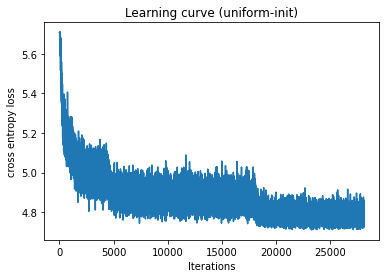

In [36]:
plt.plot(losses)

plt.title("Learning curve (uniform-init)")
plt.xlabel("Iterations")
plt.ylabel("cross entropy loss")

In [37]:
evaluate_x = Variable(test_loader.dataset.test_data.type_as(torch.FloatTensor())).cuda()
evaluate_y = Variable(test_loader.dataset.test_labels).cuda()


output = model1(evaluate_x)
pred = output.data.max(1)[1]
d = pred.eq(evaluate_y.data).cpu()
accuracy = d.sum()/d.size()[0]
#print(d)
print('Accuracy:', accuracy)

Accuracy: tensor(0.9228)


C:\Users\46145\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
C:\Users\46145\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
<ipython-input-7-6a6224c04aaa>:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(h)
